### How to use PyTorch LSTMs for time series regression

##### 1. 라이브러리 불러오기

In [1]:
import os
import pandas as pd             #데이터를 Dataframe으로 다루는 라이브러리
from pandas import DataFrame
import numpy as np              #데이터를 행열 또는 array 형태로 다루는 라이브러리
import random

from time import time
from datetime import datetime
import math
from copy import deepcopy

import matplotlib.pyplot as plt #데이터를 그래프 plot으로 보여주는 라이브러리
import seaborn as sns

import requests                 #네트워크 접근 라이브러리
from bs4 import BeautifulSoup   #웹사이트 접근하는 라이브러리

from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
torch.manual_seed(77)

from torch import nn as nn
from torch import optim
from torch.nn import functional as F
from torch import tensor

import warnings
warnings.filterwarnings('ignore')

##### 2. KRX 종목으로 주가종목 데이터 가져오기

In [2]:
target = '삼성전자'

# 종목 이름을 입력하면 종목에 해당하는 코드를 불러와
# 네이버 금융(http://finance.naver.com)에 넣어줌

code_krx = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', encoding='cp949', header=0)[0]
# 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌
code_krx.종목코드 = code_krx.종목코드.map('{:06d}'.format)
# 우리가 필요한 것은 회사명과 종목코드이기 때문에 필요없는 column들은 제외해준다.
code_krx = code_krx[['회사명', '종목코드']]
# code_krx
target_code = code_krx[code_krx['회사명']==target]
target_code

,회사명,종목코드
1808,삼성전자,005930


In [3]:
# 종목코드로 네이버에서 종목 주소 생성 확인
def get_url(code): #(item_name, code_df):
    url = 'https://finance.naver.com/item/sise_day.naver?code='+'{code}'.format(code=code).lstrip()
    return url
code = target_code['종목코드'].iloc[0]
url = get_url(code)
url

'https://finance.naver.com/item/sise_day.naver?code=005930'

In [4]:
# 위에서 찾은 네이버 타겟종목 페이지에서 마지막 페이지 크기 확인
url_page = url + '&page=1'
headers = {'User-agent':'Mozilla/5.0'}
html = requests.get(url_page, headers=headers).text
soup = BeautifulSoup(html,"html.parser")
tags = soup.find_all('a')
# print(tags[11]["href"])
last_page = tags[11]["href"]
last_page = last_page.split('=')[2]
last_page
# print(f"target_code :회사명 == [{target_code['회사명'].iloc[0]}] 종목코드 == [{target_code['종목코드'].iloc[0]}] 마지막 페이지 == [{last_page}]")

'725'

In [5]:
last_page = 150 # 임시 150 페이지 까지만

# 일 데이터를 담을 df_code라는 DataFrame 정의
df_code = pd.DataFrame()
url.lstrip()
for page in range(1,int(last_page)+1):
    # pg_url = ('{url}&page={page}'.format(url=url, page=page)).lstrip()
    # pg = pd.read_html(pg_url,encoding='euc-kr',header=1)[0]
    # df_code = pd.concat([df_code,pg])
    req = requests.get(f'{url}&page={page}',headers=headers)
    df_code = pd.concat([df_code,pd.read_html(req.text,encoding='euc-kr')[0]],ignore_index=True)

# df.dropna()를 이용해 결측값 있는 행 제거
df_code = df_code.dropna()
df_code.reset_index(drop=True, inplace=True)

# 상위 15개 데이터 확인하기
df_code.head(15)


,날짜,종가,전일비,시가,고가,저가,거래량
0,2025.06.04,57800.0,"상승 1,000",57200.0,57900.0,56800.0,19390304.0
1,2025.06.02,56800.0,상승 600,56300.0,57300.0,56200.0,12870515.0
2,2025.05.30,56200.0,상승 100,56200.0,57200.0,55800.0,26219683.0
3,2025.05.29,56100.0,상승 200,56200.0,56400.0,55600.0,12936810.0
4,2025.05.28,55900.0,"상승 2,000",54300.0,56100.0,54200.0,17516283.0
5,2025.05.27,53900.0,하락 800,54200.0,54500.0,53800.0,13439520.0
6,2025.05.26,54700.0,상승 500,53900.0,55000.0,53700.0,10901337.0
7,2025.05.23,54200.0,하락 500,55000.0,55200.0,54100.0,11247115.0
8,2025.05.22,54700.0,"하락 1,000",55300.0,55500.0,54500.0,15254278.0
9,2025.05.21,55700.0,하락 200,56200.0,56600.0,55700.0,7794181.0


##### data split

In [6]:
# 한글로 된 컬럼명을 영어로 바꿔줌
stock_data = df_code.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'})
stock_data['diff'] = stock_data['diff'].str.replace('상승','').str.replace('하락','').str.replace('보합','').str.replace(',','').str.replace(' ','').str.strip()
# 데이터의 타입을 int형으로 바꿔줌
stock_data[['close', 'diff', 'open', 'high', 'low', 'volume']] = stock_data[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(float)
# 컬럼명 'date'의 타입을 date로 바꿔줌
stock_data['date'] = pd.to_datetime(stock_data['date'])
# 일자(date)를 기준으로  정렬
stock_data = stock_data.sort_values(by=['date'],ascending = True)
# 상위 5개 데이터 확인
print(stock_data.shape)
stock_data.reset_index(drop=True, inplace=True)
stock_data.head(15)

(1500, 7)


,date,close,diff,open,high,low,volume
0,2019-04-26,44850.0,200.0,44200.0,45000.0,43800.0,9739982.0
1,2019-04-29,46150.0,1300.0,45150.0,46150.0,45100.0,8777517.0
2,2019-04-30,45850.0,300.0,46000.0,46300.0,45350.0,11121273.0
3,2019-05-02,45900.0,50.0,45500.0,46150.0,45400.0,8625126.0
4,2019-05-03,45300.0,600.0,45900.0,46050.0,45300.0,6562916.0
5,2019-05-07,44850.0,450.0,45250.0,45300.0,44400.0,12014907.0
6,2019-05-08,44250.0,600.0,44300.0,44850.0,44200.0,10398754.0
7,2019-05-09,42450.0,1800.0,43900.0,44250.0,42450.0,23029718.0
8,2019-05-10,42900.0,450.0,42600.0,43450.0,42450.0,14579512.0
9,2019-05-13,42650.0,250.0,42500.0,43200.0,42350.0,7635079.0


In [7]:
df = stock_data.copy()
df = df.set_index('date')
df

,close,diff,open,high,low,volume
date,,,,,,
2019-04-26,44850.0,200.0,44200.0,45000.0,43800.0,9739982.0
2019-04-29,46150.0,1300.0,45150.0,46150.0,45100.0,8777517.0
2019-04-30,45850.0,300.0,46000.0,46300.0,45350.0,11121273.0
2019-05-02,45900.0,50.0,45500.0,46150.0,45400.0,8625126.0
2019-05-03,45300.0,600.0,45900.0,46050.0,45300.0,6562916.0
...,...,...,...,...,...,...
2025-05-28,55900.0,2000.0,54300.0,56100.0,54200.0,17516283.0
2025-05-29,56100.0,200.0,56200.0,56400.0,55600.0,12936810.0
2025-05-30,56200.0,100.0,56200.0,57200.0,55800.0,26219683.0


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

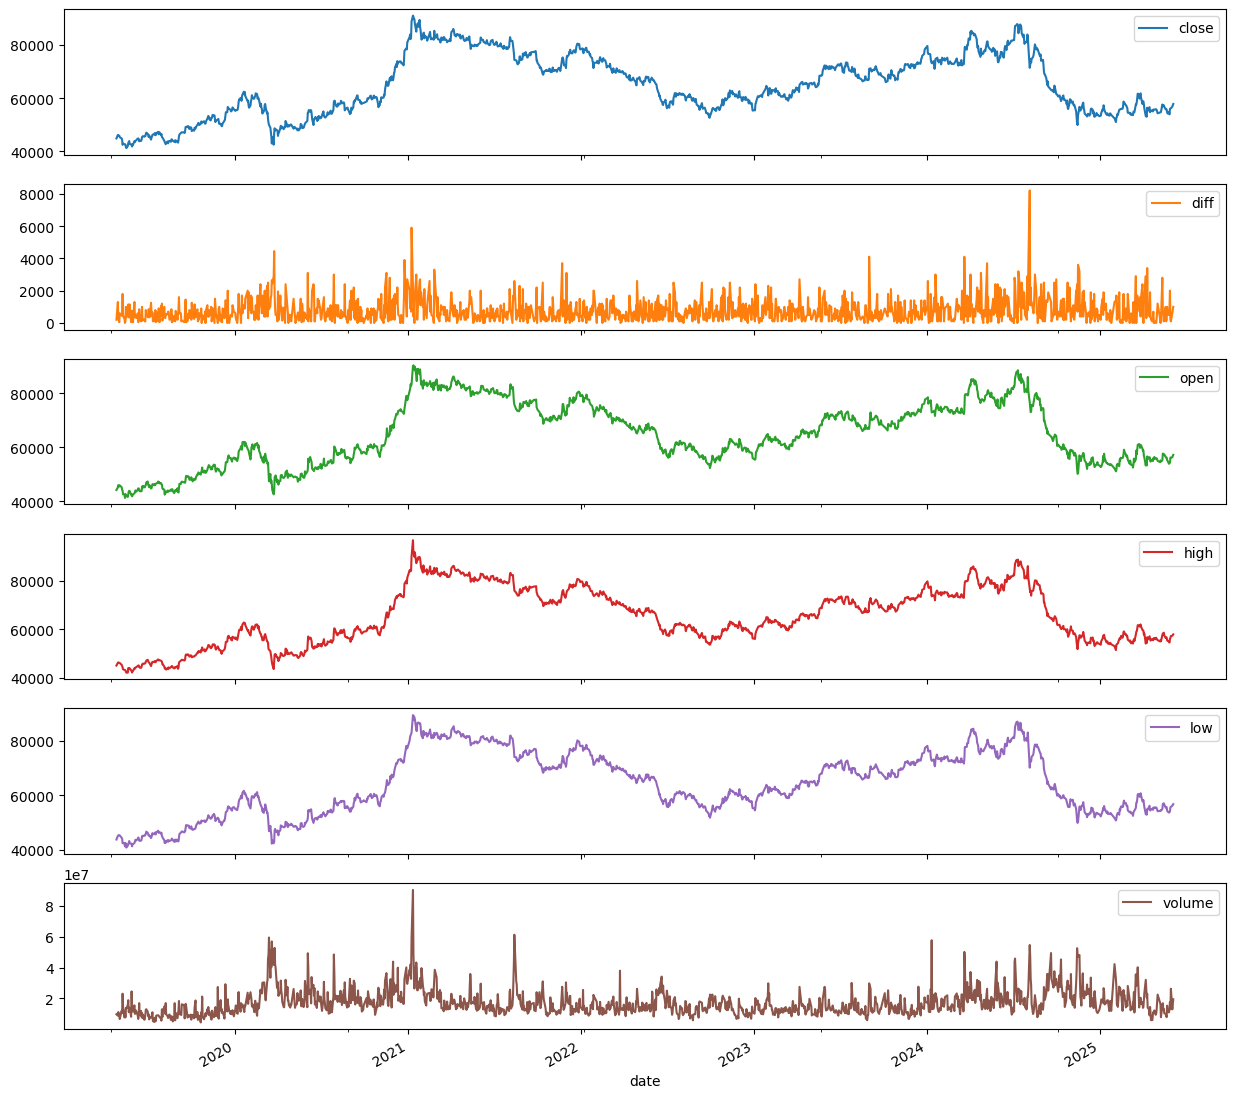

In [8]:

df.plot(subplots=True, figsize=(15,15))

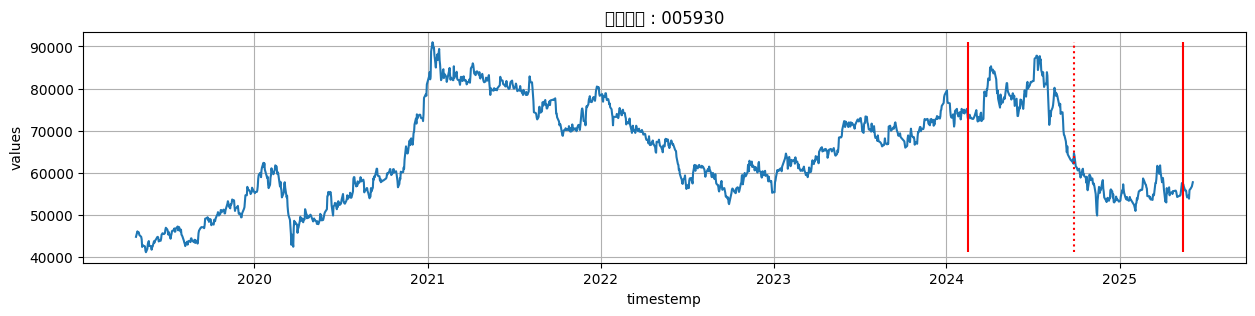

In [9]:
fig, ax = plt.subplots(1,1, figsize=(15,3))
ax.plot(df['close'])
ax.vlines(df[df.index == df.iloc[round(len(df)*0.79)].name].index,
          ymax=(max(df['close'])+2), 
          ymin=(min(df['close'])-1), colors='red', linestyles= '-')
ax.vlines(df[df.index == df.iloc[round(len(df)*0.89)].name].index,
          ymax=(max(df['close'])+2), 
          ymin=(min(df['close'])-1), colors='red', linestyles= ':')
ax.vlines(df[df.index == df.iloc[round(len(df)*0.99)].name].index,
          ymax=(max(df['close'])+2), 
          ymin=(min(df['close'])-1), colors='red', linestyles= '-')
ax.set_title(target + ' : ' + code)
ax.set_xlabel('timestemp')
ax.set_ylabel('values')
ax.grid()
fig.tight_layout
plt.show()

In [10]:
# 데이터를 훈련, 검증, 테스트로 나눈다.
df_train = df.iloc[:round(len(df)*0.8)]
df_valid = df.iloc[round(len(df)*0.8):round(len(df)*0.9)]
df_test = df.iloc[round(len(df)*0.9):len(df)]

print(f" df.shape 0.8 : {round(df.shape[0]*0.8)}")
print(f" df_train.shape : {df_train.shape}")
print(f" df_valid.shape : {df_valid.shape}")
print(f" df_test.shape : {df_test.shape}")
print(f" check {(round(df.shape[0]*0.7)) == df_train.shape[0]+df_valid.shape[0]+df_test.shape[0]}")

 df.shape 0.8 : 1200
 df_train.shape : (1200, 6)
 df_valid.shape : (150, 6)
 df_test.shape : (150, 6)
 check False


In [11]:
df_train

,close,diff,open,high,low,volume
date,,,,,,
2019-04-26,44850.0,200.0,44200.0,45000.0,43800.0,9739982.0
2019-04-29,46150.0,1300.0,45150.0,46150.0,45100.0,8777517.0
2019-04-30,45850.0,300.0,46000.0,46300.0,45350.0,11121273.0
2019-05-02,45900.0,50.0,45500.0,46150.0,45400.0,8625126.0
2019-05-03,45300.0,600.0,45900.0,46050.0,45300.0,6562916.0
...,...,...,...,...,...,...
2024-02-29,73400.0,200.0,72600.0,73400.0,72000.0,21176403.0
2024-03-04,74900.0,1500.0,74300.0,75000.0,74000.0,23210474.0
2024-03-05,73700.0,1200.0,74600.0,74800.0,73700.0,19505125.0


In [12]:
scaler = StandardScaler()
scaler.fit(df_train)
df_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df.columns)
df_valid_scaled = pd.DataFrame(scaler.transform(df_valid),columns=df.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df.columns)

In [13]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5, predict_length=1):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.predict_length = predict_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()
        self.datetime = dataframe.index 

    def __len__(self):
        return len(self.X) - (self.sequence_length + self.predict_length)
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.sequence_length
        seq_x = self.X[s_begin:s_end]
        r_begin = s_end - self.predict_length
        r_end = r_begin + self.predict_length
        seq_y = self.y[r_begin :r_end]
        return seq_x, seq_y

 # start point padding type
    # def __len__(self):
    #     return self.X.shape[0]

    # def __getitem__(self, i): 
    #     if i >= self.sequence_length - 1:
    #         i_start = i - self.sequence_length + 1
    #         x = self.X[i_start:(i + 1), :]
    #     else:
    #         padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
    #         x = self.X[0:(i + 1), :]
    #         x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [14]:
target='close'
features= df.columns
sequence_length = 12
predict_length = 1

train_dataset = SequenceDataset(
    df_train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)

i = 27
X, y = train_dataset[i]
print(X)
print(y)

tensor([[-1.7698, -0.6600, -1.8213, -1.7964, -1.7933, -0.5799],
        [-1.7175, -0.1959, -1.7604, -1.7531, -1.7408, -0.9420],
        [-1.7131, -1.0467, -1.7169, -1.7401, -1.6971, -1.2085],
        [-1.7349, -0.7373, -1.7169, -1.7358, -1.7189, -0.9652],
        [-1.8091,  0.1909, -1.7691, -1.7921, -1.7977,  0.0742],
        [-1.7873, -0.7373, -1.8083, -1.8138, -1.8065, -0.8756],
        [-1.7960, -0.9694, -1.8083, -1.8224, -1.7977, -0.5540],
        [-1.7567, -0.4279, -1.8083, -1.7834, -1.7758, -1.0419],
        [-1.6695,  0.4229, -1.6603, -1.7011, -1.6577, -0.7385],
        [-1.6564, -0.8920, -1.7125, -1.6968, -1.6708, -1.1480],
        [-1.6389, -0.8147, -1.6342, -1.6708, -1.6402, -0.8590],
        [-1.6564, -0.8147, -1.6821, -1.6708, -1.6402, -1.2811]])
tensor([-1.6564])


In [15]:
X, y = train_dataset[i+1]
print(X)
print(y)

tensor([[-1.7175, -0.1959, -1.7604, -1.7531, -1.7408, -0.9420],
        [-1.7131, -1.0467, -1.7169, -1.7401, -1.6971, -1.2085],
        [-1.7349, -0.7373, -1.7169, -1.7358, -1.7189, -0.9652],
        [-1.8091,  0.1909, -1.7691, -1.7921, -1.7977,  0.0742],
        [-1.7873, -0.7373, -1.8083, -1.8138, -1.8065, -0.8756],
        [-1.7960, -0.9694, -1.8083, -1.8224, -1.7977, -0.5540],
        [-1.7567, -0.4279, -1.8083, -1.7834, -1.7758, -1.0419],
        [-1.6695,  0.4229, -1.6603, -1.7011, -1.6577, -0.7385],
        [-1.6564, -0.8920, -1.7125, -1.6968, -1.6708, -1.1480],
        [-1.6389, -0.8147, -1.6342, -1.6708, -1.6402, -0.8590],
        [-1.6564, -0.8147, -1.6821, -1.6708, -1.6402, -1.2811],
        [-1.6477, -0.9694, -1.6821, -1.6708, -1.6402, -1.1569]])
tensor([-1.6477])


In [16]:
print(df_train[features].iloc[i: (i + sequence_length)])

              close    diff     open     high      low      volume
date                                                              
2019-06-07  44200.0   300.0  43600.0  44350.0  43450.0  11683682.0
2019-06-10  44800.0   600.0  44300.0  44850.0  44050.0   8792182.0
2019-06-11  44850.0    50.0  44800.0  45000.0  44550.0   6664872.0
2019-06-12  44600.0   250.0  44800.0  45050.0  44300.0   8607439.0
2019-06-13  43750.0   850.0  44200.0  44400.0  43400.0  16906541.0
2019-06-14  44000.0   250.0  43750.0  44150.0  43300.0   9322873.0
2019-06-17  43900.0   100.0  43750.0  44050.0  43400.0  11890424.0
2019-06-18  44350.0   450.0  43750.0  44500.0  43650.0   7994928.0
2019-06-19  45350.0  1000.0  45450.0  45450.0  45000.0  10417690.0
2019-06-20  45500.0   150.0  44850.0  45500.0  44850.0   7147785.0
2019-06-21  45700.0   200.0  45750.0  45800.0  45200.0   9454913.0
2019-06-24  45500.0   200.0  45200.0  45800.0  45200.0   6085066.0


In [17]:
def my_collate_fn(batch):
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    # batch_first=True로 설정
    padded_batch = pad_sequence(batch, batch_first=True, padding_value=0) # padding_value는 선택 
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return padded_batch #, labels_tensor

In [25]:
target = 'close'
features = df_train_scaled.columns
batch_size = 30
sequence_length = 12
predict_length = 1

train_dataset = SequenceDataset(
    df_train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)
valid_dataset = SequenceDataset(
    df_valid_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)
test_dataset = SequenceDataset(
    df_test_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)#, collate_fn=my_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)#, collate_fn=my_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)#,collate_fn=my_collate_fn)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([30, 12, 6])
Target shape: torch.Size([30, 1])


In [19]:
# df_train.describe()
mean = df_train.mean()
var = df_train.var()

### LSTM Model

In [35]:
class LSTM_Layer(nn.Module):
    def __init__(self, 
                 num_features, 
                 hidden_units,
                 predict_length, 
                 bias=True, 
                 num_layers=3, 
                 drop_ratio=0.0,
                 bi_dir=False,
                 device='cpu'):
        super().__init__()
        self.num_features = num_features  # feature's = 현재 1
        self.hidden_units = hidden_units
        self.bias = bias
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.bi_dir = bi_dir
        self.device = device

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            bias=bias,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=drop_ratio,
            bidirectional=bi_dir
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=predict_length, bias=bias)

        self.sig = nn.Sigmoid()
        self.Tanh = nn.Tanh()

    def forward(self, x):
        # print(f"x.shape-ori: {x.shape}")
        # x = x.unsqueeze(2)
        # print(f"x.shape-unsqz : {x.shape}")
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.device)
        hh, (hn, _) = self.lstm(x, (h0, c0))
        # print(f"hh.shape {hh.shape}")
        # raise
        out = self.linear(hh[:,-1:])

        return out

In [27]:
len(features)

6

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"is_available device : {device}")

learning_rate = 0.003
num_hidden_units = 124
epochs = 50

model = LSTM_Layer(num_features=len(features), hidden_units=num_hidden_units, predict_length=predict_length, device=device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


is_available device : cuda


In [38]:
def train_model(data_loader, model, loss_function, optimizer, device):
    num_batches = len(data_loader)
    total_loss = 0
    model.to(device)
    
    model.train()
    for i, (X, y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def eval_model(data_loader, model, loss_function, device=device):
    num_batches = len(data_loader)
    total_loss = 0
    
    model.to(device)

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            # print(f"input x : {X.shape}")
            # print(f"label y : {y.shape}")
            # print(f"output : {output.shape}")
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"eval loss: {avg_loss}")
    return avg_loss


def infer_model(data_loader, model, device=device):
    num_batches = len(data_loader)
    total_loss = 0
    predict = []
    label = []
    model.to(device)

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            # print(output.shape)
            # raise
            pred = output.to('cpu').numpy()
            np.squeeze(pred)
            predict.append(list(pred[0]))
            true = y.to('cpu').numpy()
            np.squeeze(true)
            label.append(list(true[0]))
        
    return predict, label


def forecasting (data, model, device=device):
    model.to(device)
    model.eval()
    with torch.no_grad():
            X = torch.from_numpy(data).to(torch.float32).to(device)
            X = X.unsqueeze(0)
            output = model(X)
            forecast = output.to('cpu').numpy()
            forecast = np.squeeze(forecast[0])
        
    return forecast


In [37]:
print("Untrained evaluate\n--------")
eval_model(valid_loader, model, loss_function, device=device)
print()

epoch = []
train_loss_list = []
eval_loss_list = []

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer, device=device)
    eval_loss = eval_model(valid_loader, model, loss_function, device=device)
    print()
    epoch.append(ix_epoch+1)
    train_loss_list.append(train_loss)
    eval_loss_list.append(eval_loss)
result = pd.DataFrame({'epoch':epoch, 'train_loss':train_loss_list, 'eval':eval_loss_list})
result


Untrained evaluate
--------
input x : torch.Size([30, 12, 6])
label y : torch.Size([30, 1])
output : torch.Size([30, 1, 1])
input x : torch.Size([30, 12, 6])
label y : torch.Size([30, 1])
output : torch.Size([30, 1, 1])
input x : torch.Size([30, 12, 6])
label y : torch.Size([30, 1])
output : torch.Size([30, 1, 1])
input x : torch.Size([30, 12, 6])
label y : torch.Size([30, 1])
output : torch.Size([30, 1, 1])
eval loss: 1.8262733966112137

Epoch 0
---------
Train loss: 0.9870490691600702
input x : torch.Size([30, 12, 6])
label y : torch.Size([30, 1])
output : torch.Size([30, 1, 1])
input x : torch.Size([30, 12, 6])
label y : torch.Size([30, 1])
output : torch.Size([30, 1, 1])
input x : torch.Size([30, 12, 6])
label y : torch.Size([30, 1])
output : torch.Size([30, 1, 1])
input x : torch.Size([30, 12, 6])
label y : torch.Size([30, 1])
output : torch.Size([30, 1, 1])
eval loss: 1.5823235511779785

Epoch 1
---------
Train loss: 0.9849240000431354
input x : torch.Size([30, 12, 6])
label y : 

,epoch,train_loss,eval
0,1,0.987049,1.582324
1,2,0.984924,1.671067
2,3,0.982125,1.657565
3,4,0.980016,1.682114
4,5,0.979423,1.579005
5,6,0.983654,1.732286
6,7,0.983870,1.675040
7,8,0.990965,1.731093
8,9,0.985448,1.681568
9,10,0.980083,1.706585


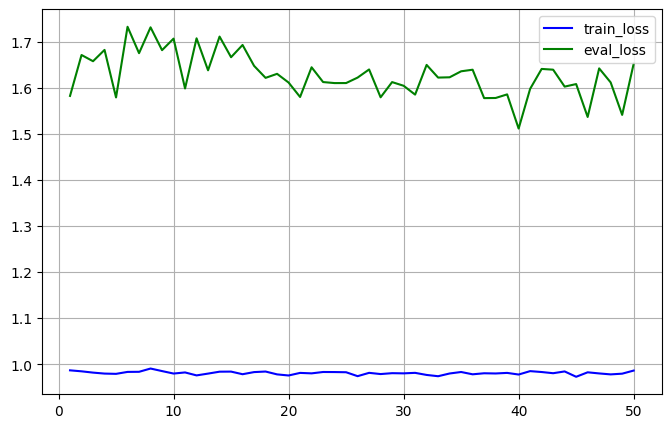

In [39]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(result['epoch'],result['train_loss'], color='blue', label='train_loss')
ax.plot(result['epoch'],result['eval'], color='green', label='eval_loss')
ax.legend()
ax.grid()
plt.show()

In [40]:
predict, trues = infer_model(test_loader, model=model, device=device)


In [41]:
predict = np.array(predict).squeeze()
trues = np.array(trues).squeeze()
infer_result = pd.DataFrame({'predict': predict, 'trues': trues}, index=test_dataset.datetime[13:])



In [42]:
infer_result.index = df_test.index[13:]
infer_result

,predict,trues
date,,
2024-11-08,-0.001428,-0.626812
2024-11-11,0.001804,-0.609362
2024-11-12,-0.003479,-0.652988
2024-11-13,-0.016885,-0.827491
2024-11-14,-0.017042,-1.001995
...,...,...
2025-05-28,-0.006726,-0.853667
2025-05-29,-0.011060,-0.923468
2025-05-30,-0.016794,-0.748965


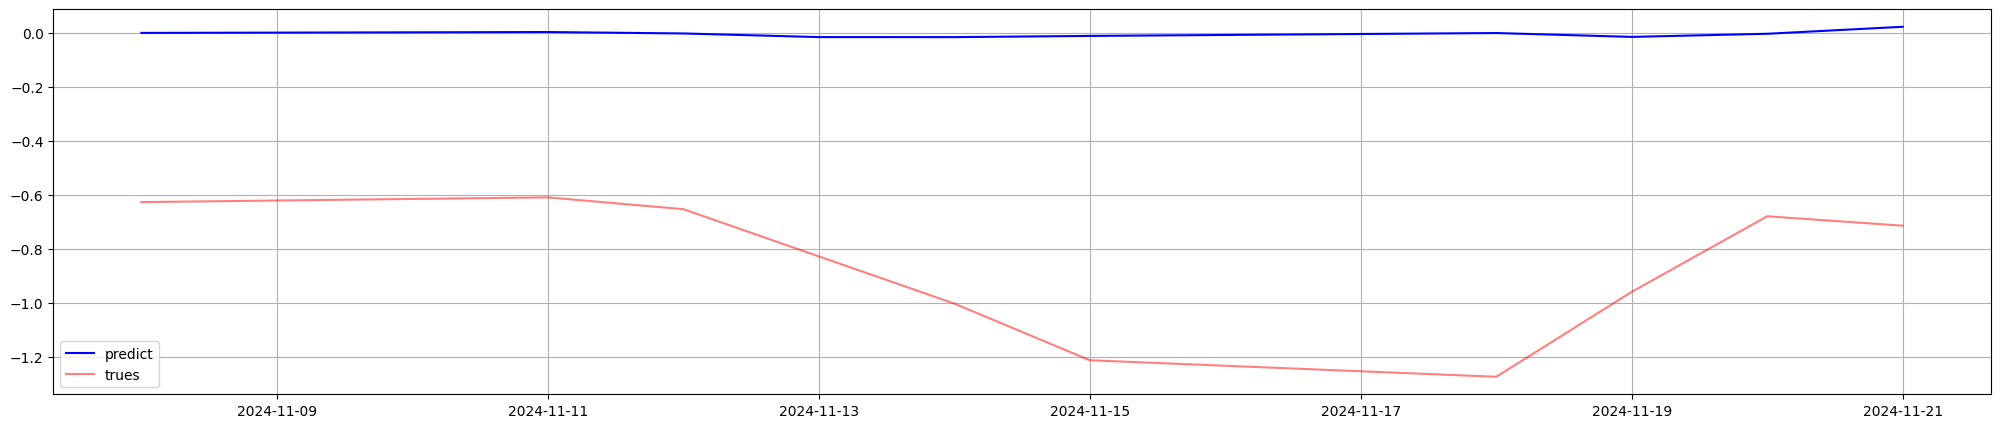

In [43]:
fig, ax = plt.subplots(1,1,figsize=(25,5))
ax.plot(infer_result['predict'].iloc[:10], color='blue', label='predict')
ax.plot(infer_result['trues'].iloc[:10], color='red', ls='-', alpha = 0.5, label='trues')
ax.legend()
ax.grid()
plt.show()

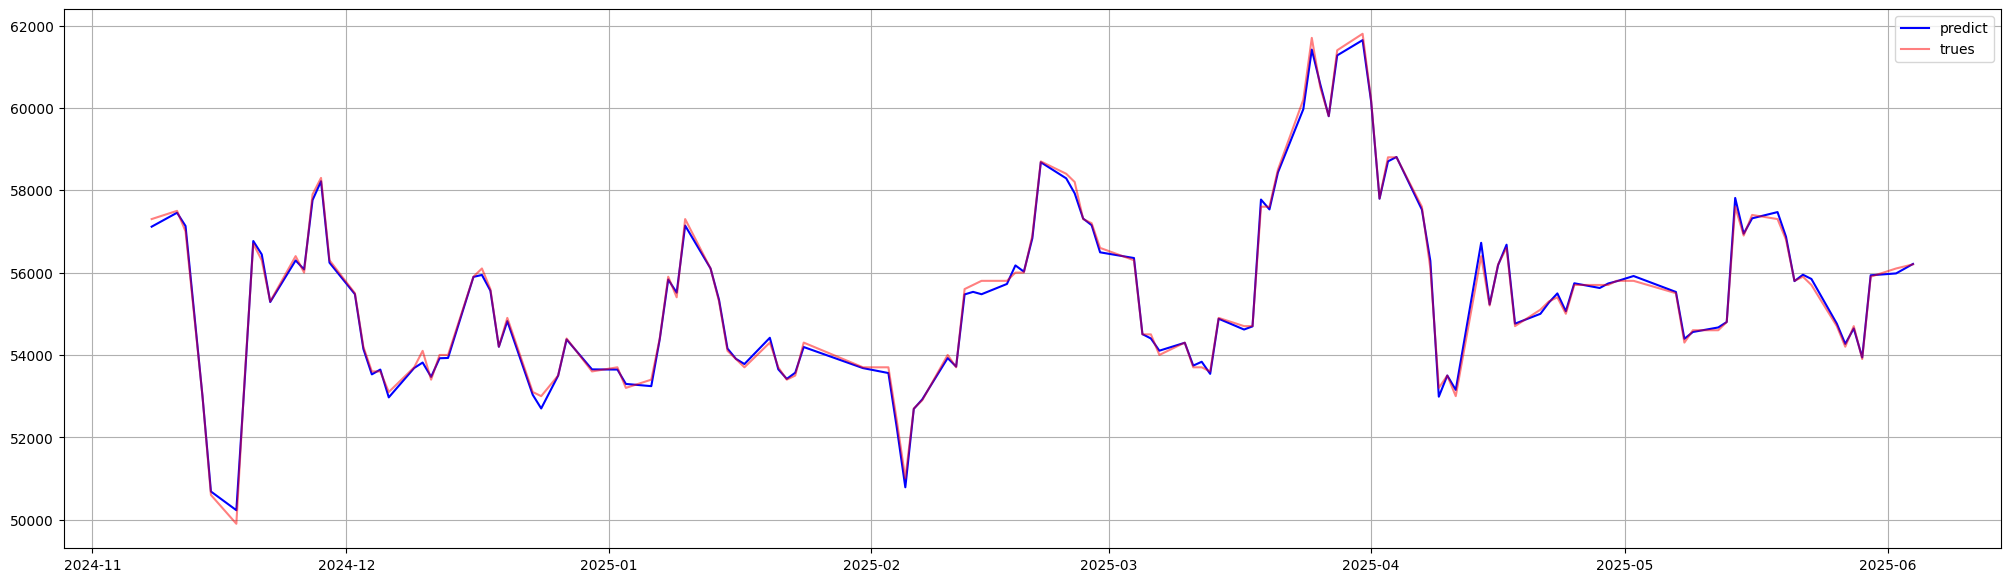

In [ ]:
mean = scaler.mean_
var = scaler.var_

df_test_pred_descaled = (infer_result['predict'] * np.sqrt(var[0])) + mean[0]
df_test_gt_descaled = (infer_result['trues'] * np.sqrt(var[0])) + mean[0]

fig, ax = plt.subplots(1,1,figsize=(25,7))
ax.plot(df_test_pred_descaled, color='blue', label='predict')
ax.plot(df_test_gt_descaled, color='red', ls='-', alpha = 0.5, label='trues')
ax.legend()
ax.grid()
plt.show()

In [ ]:
pred_input = df_test.iloc[138:150,:]
pred_input = scaler.transform(pred_input)
pred_input.shape

(12, 6)

In [ ]:
forecast = forecasting(pred_input, model=model, device=device)

In [ ]:
forecast * np.sqrt(scaler.var_[0]) + scaler.mean_[0]

57703.19397562876


## [Seq 2 Seq : stock price](https://www.kaggle.com/code/arezalo/lstm-stock-price-predition-by-pytorch)

<img src="https://miro.medium.com/v2/resize:fit:1400/1*bDANsXS4eqiLBX_iS1NHjQ.jpeg">

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, inputs):
        context_vector = self.encoder(inputs)
        outputs = self.decoder(context_vector)
        return outputs

<img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*UTlM-lb4156iwVBqgupLlw.jpeg">

<img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*fYw_890Nw7lCHNV8mFep9g.jpeg">

In [44]:
target = 'close'
features = df_train_scaled.columns
batch_size = 30
sequence_length = 25
predict_length = 7

train_dataset = SequenceDataset(
    df_train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)
valid_dataset = SequenceDataset(
    df_valid_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)
test_dataset = SequenceDataset(
    df_test_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)#, collate_fn=my_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)#, collate_fn=my_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)#,collate_fn=my_collate_fn)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([30, 25, 6])
Target shape: torch.Size([30, 7])


In [45]:
class Encoder(nn.Module):
    def __init__(self, 
                 num_features, 
                 hidden_units,
                 predict_length, 
                 bias=True, 
                 num_layers=3, 
                 drop_ratio=0.0,
                 bi_dir=False,
                 device='cpu'):
        super().__init__()
        self.num_features = num_features  # feature's = 현재 1
        self.hidden_units = hidden_units
        self.bias = bias
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.bi_dir = bi_dir
        self.device = device

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            bias=bias,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=drop_ratio,
            bidirectional=bi_dir
        )

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.device)
        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))

        return out, (hidden_state, cell_state)

In [46]:
class Decoder(nn.Module):
    def __init__(self, 
                 num_features, 
                 hidden_units,
                 predict_length, 
                 bias=True, 
                 num_layers=3, 
                 drop_ratio=0.0,
                 bi_dir=False,
                 device='cpu'):
        super().__init__()
        self.num_features = num_features  # feature's = 현재 1
        self.hidden_units = hidden_units
        self.bias = bias
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.bi_dir = bi_dir
        self.device = device

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            bias=bias,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=drop_ratio,
            bidirectional=bi_dir
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1, bias=bias)

    def forward(self, initial_input, encoder_outputs, hidden, targets, 
                teacher_force_probability):
        
        decoder_sequence_length = targets.shape[1]
        outputs = torch.full_like(targets, 0).to(self.device)
        
        for t in range(decoder_sequence_length):            
            input_at_t = initial_input.unsqueeze(1)
            output, hidden = self.lstm(input_at_t, hidden)

            # outputs[:,t] = self.linear(output)
            outputs[:,t]  = self.linear(output).squeeze()
            # outputs[:,t] = out
            # print(f"out.shape : {out.shape}")
            # print(f"outputs[:,t].shape : {outputs[:,t].shape}")

            # Set-up input for next timestep
            teacher_force = random.random() < teacher_force_probability
            # The next timestep's input will either be this timestep's 
            # target or output
            input_at_t = targets[:,t] if teacher_force else outputs[:,t]

        return outputs

    # def forecast(self, initial_input, encoder_outputs, hidden, predict_length):
    #     outputs = torch.zeros_like((predict_length)).to(self.device)
    #     input_at_t = initial_input
    #     for t in range(predict_length):            
    #         output, hidden = self.lstm(input_at_t, hidden)
    #         outputs[t] = self.linear(output)
    #         input_at_t = outputs[t]
    #     return outputs

In [47]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, encoder_inputs, targets, teacher_force_probability):
        encoder_outputs, hidden = self.encoder(encoder_inputs)
        
        outputs = self.decoder(encoder_inputs[:,-1,:], encoder_outputs,
                               hidden, targets, teacher_force_probability)
        return outputs

    # def forecast(self, encoder_inputs, predict_length):
    #     encoder_outputs, hidden = self.encoder(encoder_inputs)
    #     outputs = self.decoder.forecast(encoder_inputs[-1], encoder_outputs,
    #                            hidden, predict_length)
        # return outputs

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f" 🤗 is_available device : \n\t{device}")

epochs = 30

learning_rate = 0.03
num_hidden_units = 124
hidden_size = 256
teacher_force_probability = 0.5

seq2seq = Seq2Seq(
                    Encoder(
                            num_features = len(features), 
                            hidden_units = num_hidden_units,
                            predict_length = predict_length, 
                            bias=True, 
                            num_layers=3, 
                            drop_ratio=0.0,
                            bi_dir=False,
                            device=device), 
                    Decoder(
                            num_features = len(features), 
                            hidden_units = num_hidden_units,
                            predict_length = predict_length, 
                            bias=True, 
                            num_layers=3, 
                            drop_ratio=0.0,
                            bi_dir=False,
                            device=device),
                )

loss_function = nn.MSELoss()
# loss_function = nn.L1Loss()

optimizer = torch.optim.Adam(seq2seq.parameters(), lr=learning_rate)

print(f"\n 🤩 loss_function : \n\t{loss_function}\n")
print(f" 🤓 optimizer : \n\t{optimizer}")

 🤗 is_available device : 
	cuda

 🤩 loss_function : 
	MSELoss()

 🤓 optimizer : 
	Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.03
    maximize: False
    weight_decay: 0
)


In [49]:
def train_model(data_loader, model, loss_function, optimizer, device, teacher_force_probability):
    num_batches = len(data_loader)
    total_loss = 0
    model.to(device)
    
    model.train()
    for i, (X, y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(device)
        output = model(X,y,teacher_force_probability)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def eval_model(data_loader, model, loss_function, device):
    num_batches = len(data_loader)
    total_loss = 0
    
    model.to(device)

    teacher_force_probability = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X, y, teacher_force_probability)

            # print(f"output.type -  output.shape: {type(output)} - {output.shape}")
            # print(f"y.shape -  y.type : {type(y)} - {y.shape}")
            # print(f"one out : {output[0,:]}")
            # print(f"loss_function(output, y) : {loss_function(output, y)}")
            # raise

            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"eval loss: {avg_loss}")
    return avg_loss


def infer_model(data_loader, model, device):
    num_batches = len(data_loader)
    total_loss = 0
    predict = []
    label = []
    model.to(device)

    teacher_force_probability = 0.0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X, y, teacher_force_probability)
            # print(output.shape)
            # raise
            pred = output.to('cpu').numpy()
            np.squeeze(pred)
            predict.append(list(pred[0]))
            true = y.to('cpu').numpy()
            np.squeeze(true)
            label.append(list(true[0]))
        
    return predict, label


# def forecasting (data, model, device, predict_length):
#     model.to(device)
#     model.eval()
#     with torch.no_grad():
#             X = torch.from_numpy(data).to(torch.float32).to(device)
#             X = X.unsqueeze(0)
#             output = model.forecast(X, predict_length)
#             forecast = output.to('cpu').numpy()
#             forecast = np.squeeze(forecast[0])
        
    # return forecast


In [52]:
print("Untrained evaluate\n--------")
eval_model(valid_loader, seq2seq, loss_function, device)
print()

epoch = []
train_loss_list = []
eval_loss_list = []

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, seq2seq, loss_function, optimizer, device, teacher_force_probability)
    eval_loss = eval_model(valid_loader, seq2seq, loss_function, device)
    print()
    epoch.append(ix_epoch+1)
    train_loss_list.append(train_loss)
    eval_loss_list.append(eval_loss)
result = pd.DataFrame({'epoch':epoch, 'train_loss':train_loss_list, 'eval':eval_loss_list})
result

Untrained evaluate
--------
eval loss: 0.1765436828136444

Epoch 0
---------
Train loss: 0.20893473384019576
eval loss: 0.6543683608373007

Epoch 1
---------
Train loss: 0.11058351515155089
eval loss: 0.10318912317355473

Epoch 2
---------
Train loss: 0.061469290209443944
eval loss: 0.09596499552329381

Epoch 3
---------
Train loss: 0.03929098788648844
eval loss: 0.07347373726467292

Epoch 4
---------
Train loss: 0.031683016078252545
eval loss: 0.05825487400094668

Epoch 5
---------
Train loss: 0.028338565417614422
eval loss: 0.048689454793930054

Epoch 6
---------
Train loss: 0.020468543700285648
eval loss: 0.0438475888222456

Epoch 7
---------
Train loss: 0.020539912346162294
eval loss: 0.04213092848658562

Epoch 8
---------
Train loss: 0.016092455039094938
eval loss: 0.041868055860201515

Epoch 9
---------
Train loss: 0.01926051124342178
eval loss: 0.04933143158753713

Epoch 10
---------
Train loss: 0.02160861985267777
eval loss: 0.05138060202201208

Epoch 11
---------
Train loss: 0

,epoch,train_loss,eval
0,1,0.208935,0.654368
1,2,0.110584,0.103189
2,3,0.061469,0.095965
3,4,0.039291,0.073474
4,5,0.031683,0.058255
5,6,0.028339,0.048689
6,7,0.020469,0.043848
7,8,0.020540,0.042131
8,9,0.016092,0.041868
9,10,0.019261,0.049331


In [ ]:

pred, gt = infer_model(test_loader, seq2seq, device)

In [ ]:
print(pred.__len__())
print(gt.__len__())
pred[0]

118
118


[-0.0761706,
 -0.07467825,
 -0.07562704,
 -0.07691832,
 -0.07792686,
 -0.078570716,
 -0.078928165]

In [ ]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

##### Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__(hidden_size)
        # Two layers are used so a non-linear act function can be placed 
        # in between
        self.initial_layer = nn.Linear(2 * hidden_size, hidden_size)
        self.final_layer = nn.Linear(hidden_size, 1)
    
    def forward(self, current_decoder_hidden, encoder_outputs):
        # NOTE: encoder_outputs is the same thing as the encoder hidden states 
        # that are output at each timestep since the encoder is only an rnn
        
        # Step 1 from diagram)
        
        # Stack decoder hidden state on top of each other encoder_outputs 
        # number of times to be able to feed into the neural network 
        # all at once
        decoder_hidden_stack = stack_decoder_hidden(current_decoder_hidden,
                                                    len(encoder_outputs))
        
        # Compare each encoder hidden state with the current hidden state
        energy = self.initial_layer(torch.cat((encoder_outputs,
                                               decoder_hidden_stack)))
        
        # Apply tanh (used in the paper) to introduce non-linearity
        energy = torch.tanh(energy)

        # Apply final layer to compress to a single value for each comparison
        energy = self.final_layer(energy)
        
        # Softmax the energy to sum them up to 1
        energy = torch.softmax(energy)
        
        # Steps 2 & 3 from diagram)
        
        # The multiplication and sum are the same as a matrix multiplication
        attn = torch.mm(weights, encoder_outputs)
        
        return attn

In [ ]:
class DecoderWithAttention(nn.Module):
    def __init__(...):
            self.attention_module = Attention(hidden_size)
            # First change is that the decoder takes X_t and 
            # the attention vector of size hidden_size
            self.rnn = nn.RNN(1 + hidden_size, hidden_size)
            ...
    
    def forward(...):
        ...
        for t in range(decoder_sequence_length):
            # Only other change is to compute the attention and 
            # feed it, along with X_t, into the decoder at each timstep t
            attention_vector = self.attention_module(hidden, encoder_outputs)
            cat_input = torch.cat((input_at_t, attention_vector))
            output, hidden = self.rnn(cat_input, hidden)